## General Overview

Neural Networks approximate multidimensional functions like $W_1x_1+W_2x_2+W_3x_3 + b = p$.  The neural network learns the values of $W_1, W_2, W_3, b$.  Where $W_i$ are the weights of the equation, $b$ is the bias term of the equation, and $x_i$ is the input to the equation.

To illustrate the training process lets walk through a simplified toy example:  we want the neural network to predict if the client will default on their credit card payments.  If the client defaults the network will output 1, if the client doesn't then it will output 0.  Let the client under question be a client that default i.e. is labelled 1.  If the neural net is working properly then $W_1x_1+W_2x_2+W_3x_3= 1$. Let the client be defined by 3 features (or variables) $x_1, x_2, x_3$. These features will be the last 3 statement payments: $x_1=300, x_2=200, x_3=100$.  The network initially guesses that $W_1=.0009, W_2=.0008, W_3=.0007$. This means the answer to $W_1x_1+W_2x_2+W_3x_3 = .0009 \cdot 3-- + .0008 \cdot 200 + .0007 \cdot 100 = .46$. How close was that guess? Use a linear loss function by taking the difference between label of the client (1) and the networks guess (.46) thus 1-.46 = .54. This number (.54) is the error. You can use calculus to determine how much each weight contributed to the error. This is often called the gradient or the error signal.  You then adjust the weight by its contribution to minimize the error. You repeat this process hundreds or thousands of times for every client in the dataset. Eventually, the neural network learns to identify which clients default and which don't.

Ultimately, we are trying to minimize our error i.e. our loss function.  In the above example, we used a linear loss function to calculate the error.  However, linear loss functions are not very effective because they do not penalize large errors well nor do they provide good error signals.  As a result, other loss functions are used such as the Mean Squared Error: $\frac{1}{N}\sum\limits_{n=0}^{N}(y-\hat{y})^2$ where $y$ is the label and \hat{y}$ is the network output.  This loss function is quadratic and forms a curve:


<img
  src ='https://i.ibb.co/zRV9pXj/MSE-plot.png'
  alt="MSE_plot.png"
  width="300" 
  height="256"
/>

The minimum of the MSE loss function is 0. The gradients are tangent functions and by taking the negative of the gradients they lead us to the minimum of the loss function.  Thus each gradient is a step towards the minimum:

<img
  src ='https://i.ibb.co/LrsW0HS/gradient-desc.png'
  alt="gradient_desc.png"
  width="300" 
  height="256"
/>

Different loss functions may have different curves, for example:

<img
  src ='https://i.ibb.co/gZDbmv5/local-global.png'
  alt="local_global.png"
  width="300" 
  height="256"
/>

Ideally, we find the global minimum but we could become trapped in local minimums instead.  Later in this notebook, we explore strategies for avoiding local minimum.

\* To simplify the example, we drop the bias term, $b$


## Import Libraries

In [0]:
# import libraries for data processing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# import libraries for training
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# set device variable according to availability of gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Preprocessing

This process consists of splitting the data into features (X) and labels (y).  The Neural Network learns to predict the labels from the features.
Additionally, the data is split into train and test sets.  Test sets are used to evaluate the model.  The model should never see the test set until it is being evaluated.

The data is normalized to ensure that all features contribute equally to the learning process.   This ensures that the model doesn't disproportionately favor certain features based on their scale or range.  Additionally, normalizing removes large outliers in the data.  Large outliers can distort the gradients during optimization, leading to instability or slow convergence during training. If features have extreme values, they can cause large weight updates that make it harder for the model to find a stable solution. By normalizing or removing outliers, the gradients during backpropagation become more stable, allowing the optimization algorithm (e.g., gradient descent) to converge more efficiently and effectively.

Finally, dataLoader objects are created to handle batch processing during training and testing.  Batch processing divides the training data into smaller subsets (i.e. batches) instead of feeding the entire dataset to the model at once. These smaller batches are processed in iterations, where the model updates its parameters after each batch.  This iterative approach helps speed up training by allowing the model to make incremental adjustments.  Batch processing also introduces some noise into the training process because each batch represents only a small, random subset of the data.  The small, random subsets highlight different patterns or correlations in the data allowing the model to take different steps during gradient descent.  This variability allows the model to escape local minima and explore a broader region of the parameter space.  This helps prevents overfitting and creates a model with better generalization.

In [0]:
# read csv file with PySpark
df_spark = spark.read.format("csv").option("header", "true").option("inferSchema", "true").option("sep", ",").load("/FileStore/tables/default_of_credit_card_clients-5.csv")

# transform from PySpark dataframe -> pandas dataframe -> numpy array (see documentation: pyspark.pandas.DataFrame.to_numpy)
data = df_spark.toPandas().to_numpy()

# create train and test sets
test_size = 0.2
seed = 0
X, y = data[:, 1:-1], data[:, -1] #Drop ID col, last col is y, rest is X.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# convert data to PyTorch tensors (TODO: find method to go from PySpark dataframe to Torch tensor directly)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

## Define the Model

In this working example, the Multi-Layer Perceptrons (MLP) will be a flexible model, constructed dynamically, that can handle different numbers of hidden layers and hidden neurons. The model will also use either ReLU or Tanh as the activation function between layers.

### Model Layers
The MLP consist of 3 layers: input, hidden, and output with activation functions in between each layer.

<img
  src ='https://i.ibb.co/DMJKNR0/mlp-diag.png'
  alt="local_global.png"
  width="484" 
  height="206"
/>

#### Input Layer
The input layer recieves the data.  Its size (i.e. number of neurons) corresponds to the number of features in the data.  This determines how much information is provided to the network.  The network cannot process more than it is given so each input feature should represent some meaningful aspect of the data for the model to learn effectively.  For this working example, the data has 24 features therefore the input layer will have 24 neurons.

#### Hidden Layer
The hidden layers sit between the input and output layers.  The weights and biases of the hidden layers capture and model the complex patterns and interactions in the data.  The number of hidden layers and the number of neurons in each layer can vary.  However, if the hidden layers are too small (too few neurons), the model might not have enough capacity to capture complex patterns. On the other hand, if the hidden layers are too large (too many neurons), the network may overfit, meaning it will learn to model the training data very well but might not generalize to new, unseen data.  The number of layers describes how "deep" the model is.  Today, "deep learning" models consists of 1000+ layers, however, in theory, it is any model with more than 3 layers.

In this working example, we experiment with different hidden layer sizes allowing us to explore different model capacities and find the best trade-off between underfitting and overfitting:

**Baseline** model is a linear mapping between the input and the output with no hidden layers.  If it performs poorly it demonstrates a need for additional non-linearity.

**Average of the input features and output labels** presents a balanced paradigm, where the hidden layer size is large enough to capture some complexity but not too large to risk overfitting. It's often a reasonable first guess when exploring MLP architectures because it creates a middle ground between a small and large hidden layer, providing some capacity to model non-linearities without making the model too complex.

**Hidden layer < input layer** forced the model to generalize better by limiting its capacity. If the problem doesn't require a large number of neurons to learn patterns effectively, reducing the hidden layer size can prevent overfitting and lead to faster training and better generalization to new data. This size also reflects the assumption that the output is simpler than the input data, as it represents a slightly reduced complexity.

**Hidden layer > input layer** increases the model’s capacity to learn more complex patterns. This can be helpful if the data is highly non-linear or has intricate relationships between the features and the target labels. A larger hidden layer gives the model more flexibility, but it also increases the risk of overfitting, especially if the dataset is small or noisy. This experiment tests whether the model benefits from increased complexity and capacity, or if it struggles with overfitting.

#### Output Layer
The output layer is the final layer of the neural networ that produces the predictions.  The number of neurons in the output layer corresponds to the number of possible outputs or classes.  This working example is a binary classification problem therefore the output layer will have 2 neurons.

### Activation Functions

The activation functions introduce non-linearity to the network.  Each layer represents lineary matrix arithmetic Ax+b=y where A is the layer weights, x is the input, b the layer bias and y the output.  If there are two layers, layer 1: $A_1x_1 + b_1 = y_1$ and layer 2: \\(A_2 x_2 + b_2 = y_2 \\).  If the output of layer 1 is the input to layer 2 then layer 2 becomes \\(A_2 x_2 + b_2 = A_2 (A_1 x_1 + b_1) + b_2 = y_2 \\) which collapses back into the linear equation \\(Ax+b\\).  However, wrapping layer outputs in a non-linear function such as a sigmoid prevents this.  In this working example, we will experiment with two common activation functions, Rectified Linear Unit (ReLU) and Tanh. 

**ReLU** is a computationally efficient activation function because it is a simple thresholding operation with the beneficial property of producing sparse activations that reduces the computational load of the model (i.e. only a portion of the neurons are activated (non-zero) at any given time).  However, the sparsity can also be a drawback because neuron's can "die" i.e. get stuck output zero for all inputs if the weights are not properly adjusted.  Additionally, the ReLU function is unbounded which means that large values can pass through leading to numerical instability.

**Tanh** has a bounded output between -1 and 1 which helps mitigate extreme values.  This makes it suitable for deep learning however this bounded output can lead to a vanishing gradient for extreme values which slow covergence.

In [0]:
# this will be saved in the hyperparameter grid later
x_features = X_train.shape[1]
y_labels = y_train.shape[0]

hidden_layer_list = [
        [],
        [int((x_features + y_labels) / 2)],
        [int(x_features * 2 / 3 + y_labels)],
        [int(x_features * 3 / 2)],
    ]

# Define the MLP Model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layer_sizes, output_size, activation='relu'):
        super(MLP, self).__init__()
        layers = []
        
        # Input Layer
        prev_size = input_size

        # Hidden Layer(s)
        for hidden_size in hidden_layer_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            prev_size = hidden_size

        # Output Layer
        layers.append(nn.Linear(prev_size, output_size))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

## Define Train and Evaluate Function

In [0]:
def train_model(model, optimizer, criterion, train_loader, num_epochs=100):
    model.train()
    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        #running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        #  running_loss += loss.item() - used to chart loss during training

def evaluate_model(model, criterion, data_loader):
    model.eval()
    total_loss = 0
    correct = 0
    outputs_total = []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == y_batch).sum().item()
            outputs_total.extend(preds.flatten().tolist())
    return total_loss / len(data_loader), correct / len(data_loader.dataset), outputs_total

## Define Hyperparameters

### Learning Rate
Scales the modification made to the models weight by the gradient.  In other words, the leraning rate defines how large a step is made in the direction that minimizes the error.  Smaller learning rates allow for finer adjustments and more precise convergence.  However, it can lead slower training with the risk of getting stuck in suboptimal local minima.  Large training rates lead to faster covergence but they can overshoot the optimal solution causing the model to oscilate around the minimum failing to converge and leading to unstable training.  Generally, adaptive learning rates are used where larger learning rates are used at the beginning of the training and smaller learning rates at the end.

### Regularization
Prevent overfitting by adding a penalty to the loss function based on the size of the weights, encouraging the model to keep the weights small. This helps to simplify the model and reduce its complexity, making it more likely to generalize well to new, unseen data.

### Momentum
Accumulates past gradient information to build up speed in the direction that reduces the loss function, while dampening oscillations in directions that are less important. This can lead to faster convergence, particularly in scenarios where the loss function has narrow, steep valleys and wide flat regions, or when there are noisy gradients.  A common value used is .9 because it allows more of the previous gradients to be retained. This helps the optimizer push through shallow areas of the loss function and speed up convergence.

### Epoch
Refers to one complete pass through the entire training dataset during the training process.

In [0]:
# Hyperparameter grid

# Use this if you want to experiment with different hyper parameter configurations
#param_grid = {
#    "learning_rate_init": np.logspace(-3, -1, 3),
#    "alpha": np.logspace(-4, -2, 3),
#    "activation": ['relu', 'tanh'],
#    "hidden_layer_sizes": hidden_layer_list
#}

# param grid to train a single model
param_grid = {
    "learning_rate_init": np.array(0.001),
    "alpha": np.array(0),
    "activation": ['tanh'],
    "hidden_layer_sizes": [int((x_features + y_labels) / 2)]
}

momentum = 0.9
num_epochs = 500

## Train Loop

In [0]:
best_model = None
best_score = 0

# Train Loop
#for params in ParameterGrid(param_grid): # use if experimenting with different hyper parameter configurations
for params in [param_grid]:
    # Build model with current hyperparameters
    model = MLP(input_size=X_train.shape[1],
                hidden_layer_sizes=params['hidden_layer_sizes'],
                output_size=len(np.unique(y_train)),
                activation=params['activation']).to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=params['learning_rate_init'], momentum=momentum, weight_decay=params['alpha'])
    
    # Train the model
    train_model(model, optimizer, criterion, train_loader, num_epochs=num_epochs)
    
    # Evaluate on test set
    test_loss, test_accuracy, outputs = evaluate_model(model, criterion, test_loader)
    
    # Track the best performing model
    if test_accuracy > best_score:
        best_score = test_accuracy
        best_model = model
        best_params = params

# Evaluate final model
train_loss, train_accuracy, _ = evaluate_model(best_model, criterion, train_loader)

# Save predictions for confusion matrix
test_loss, test_accuracy, predictions = evaluate_model(best_model, criterion, test_loader) 

results = {
    "params": best_params,
    "train loss":  train_loss,
    "train accuracy": train_accuracy,
    "test loss": test_loss,
    "test accuracy": test_accuracy
}

Epochs: 100%|██████████| 500/500 [18:06<00:00,  2.17s/it]


## Results

In [0]:
best_params = results["params"]
final_train_accuracy = results["train accuracy"]
final_test_accuracy = results["test accuracy"]

print(f"Best params: {best_params}")
print(f"Final Train Accuracy: {train_accuracy*100}%")
print(f"Final Test Accuracy: {test_accuracy*100}%")

Best params: {'learning_rate_init': array(0.001), 'alpha': array(0), 'activation': ['tanh'], 'hidden_layer_sizes': [12011]}
Final Train Accuracy: 0.8107916666666667
Final Test Accuracy: 0.8201666666666667


### Confusion Matrix

Accuracy can be misleading on imbalanced datasets.  A confusion matrix shows the breakdown of true positives, true negatives, false positives, and false negatives.

<img
  src ='https://i.ibb.co/dmBHnNV/conf-mat.png'
  alt = "conf_mat.png"
  width="300" 
  height="256"
/>

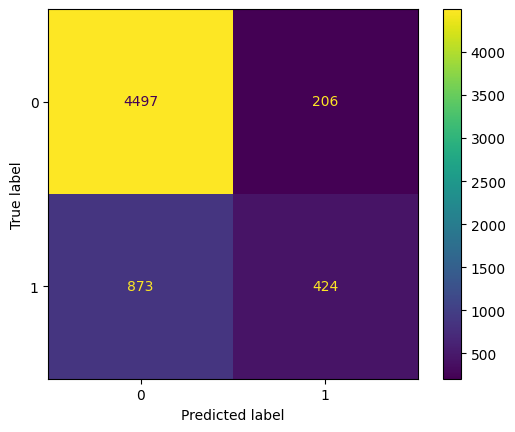

In [0]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(cm).plot()

From the above figure, it can be observed that the model has a bias toward false positives.  This makes sense given the dataset ratio between default (22%) and non-default (77%) data points.  As a result, the model might benefit from a more balanced dataset.  However, there are other tweaks that can be made to the training pipeline such as stratified cross-validation which ensures that the class distribution is consistent across training and test sets. This prevents overfitting to the majority class, which can sometimes lead to a high false positive rate.